<a href="https://colab.research.google.com/github/grazder/recommendation_systems/blob/main/HW_1_RECSYS_HSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Матричные факторизации

В данной работе вам предстоит познакомиться с практической стороной матричных разложений.
Работа поделена на 4 задания:
1. Вам необходимо реализовать SVD разложения используя SGD на explicit данных
2. Вам необходимо реализовать матричное разложения используя ALS на implicit данных
3. Вам необходимо реализовать матричное разложения используя BPR на implicit данных
4. Вам необходимо реализовать матричное разложения используя WARP на implicit данных

Мягкий дедлайн 13 Октября (пишутся замечания, выставляется оценка, есть возможность исправить до жесткого дедлайна)

Жесткий дедлайн 20 Октября (Итоговая проверка)

In [1]:
!pip install implicit

     |████████████████████████████████| 1.1 MB 6.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for implicit: filename=implicit-0.4.8-cp37-cp37m-linux_x86_64.whl size=4606559 sha256=28a34b497d64d7469d82ec241128cab55b31850dc0e8da7ca32e66d11c18e346
  Stored in directory: /root/.cache/pip/wheels/88/e6/34/25e73cccbaf1a961154bb562a5f86123b68fdbf40e306073d6
Successfully built implicit


In [2]:
!unzip ml-1m.zip

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [3]:
!pip install lightfm

     |████████████████████████████████| 310 kB 5.4 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705387 sha256=9281d04b1cda8309c4d2f5c2990e7b91e9d86c67904fda84ba4fb25edf51822b
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built lightfm


In [59]:
import implicit
import pandas as pd
import numpy as np
import scipy.sparse as sp
from scipy.sparse.csr import csr_matrix
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

from lightfm.datasets import fetch_movielens

В данной работе мы будем работать с explicit датасетом movieLens, в котором представленны пары user_id movie_id и rating выставленный пользователем фильму

Скачать датасет можно по ссылке https://grouplens.org/datasets/movielens/1m/

In [5]:
ratings = pd.read_csv('ml-1m/ratings.dat', delimiter='::', header=None, 
        names=['user_id', 'movie_id', 'rating', 'timestamp'], 
        usecols=['user_id', 'movie_id', 'rating'], engine='python')

In [6]:
movie_info = pd.read_csv('ml-1m/movies.dat', delimiter='::', header=None, 
        names=['movie_id', 'name', 'category'], engine='python')

Explicit данные

In [7]:
ratings.head(10)

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
5,1,1197,3
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4


Для того, чтобы преобразовать текущий датасет в Implicit, давайте считать что позитивная оценка это оценка >=4

In [8]:
implicit_ratings = ratings.loc[(ratings['rating'] >= 4)]

In [9]:
implicit_ratings.head(10)

,user_id,movie_id,rating
0,1,1193,5
3,1,3408,4
4,1,2355,5
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4
10,1,595,5
11,1,938,4
12,1,2398,4


Удобнее работать с sparse матричками, давайте преобразуем DataFrame в CSR матрицы

In [10]:
users = implicit_ratings["user_id"]
movies = implicit_ratings["movie_id"]
user_item = sp.coo_matrix((np.ones_like(users), (users, movies)))
user_item_t_csr = user_item.T.tocsr()
user_item_csr = user_item.tocsr()

В качестве примера воспользуемся ALS разложением из библиотеки implicit

Зададим размерность латентного пространства равным 64, это же определяет размер user/item эмбедингов

In [11]:
model = implicit.als.AlternatingLeastSquares(factors=64, iterations=100, calculate_training_loss=True)

В качестве loss здесь всеми любимый RMSE

In [12]:
model.fit(user_item_t_csr)

  0%|          | 0/100 [00:00<?, ?it/s]

Построим похожие фильмы по 1 movie_id = Истории игрушек

In [13]:
movie_info.head(5)

,movie_id,name,category
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [14]:
get_similars = lambda item_id, model : [movie_info[movie_info["movie_id"] == x[0]]["name"].to_string() 
                                        for x in model.similar_items(item_id)]

Как мы видим, симилары действительно оказались симиларами.

Качество симиларов часто является хорошим способом проверить качество алгоритмов.

P.S. Если хочется поглубже разобраться в том как разные алгоритмы формируют разные латентные пространства, рекомендую загружать полученные вектора в tensorBoard и смотреть на сформированное пространство

In [15]:
get_similars(1, model)

['0    Toy Story (1995)',
 '3045    Toy Story 2 (1999)',
 "2286    Bug's Life, A (1998)",
 '33    Babe (1995)',
 '584    Aladdin (1992)',
 '2315    Babe: Pig in the City (1998)',
 '1838    Mulan (1998)',
 '360    Lion King, The (1994)',
 '2618    Tarzan (1999)',
 '1526    Hercules (1997)']

Давайте теперь построим рекомендации для юзеров

Как мы видим юзеру нравится фантастика, значит и в рекомендациях ожидаем увидеть фантастику

In [16]:
get_user_history = lambda user_id, implicit_ratings : [movie_info[movie_info["movie_id"] == x]["name"].to_string() 
                                            for x in implicit_ratings[implicit_ratings["user_id"] == user_id]["movie_id"]]

In [17]:
get_user_history(4, implicit_ratings)

['3399    Hustler, The (1961)',
 '2882    Fistful of Dollars, A (1964)',
 '1196    Alien (1979)',
 '1023    Die Hard (1988)',
 '257    Star Wars: Episode IV - A New Hope (1977)',
 '1959    Saving Private Ryan (1998)',
 '476    Jurassic Park (1993)',
 '1180    Raiders of the Lost Ark (1981)',
 '1885    Rocky (1976)',
 '1081    E.T. the Extra-Terrestrial (1982)',
 '3349    Thelma & Louise (1991)',
 '3633    Mad Max (1979)',
 '2297    King Kong (1933)',
 '1366    Jaws (1975)',
 '1183    Good, The Bad and The Ugly, The (1966)',
 '2623    Run Lola Run (Lola rennt) (1998)',
 '2878    Goldfinger (1964)',
 '1220    Terminator, The (1984)']

Получилось! 

Мы действительно порекомендовали пользователю фантастику и боевики, более того встречаются продолжения тех фильмов, которые он высоко оценил

In [18]:
get_recommendations = lambda user_id, model : [movie_info[movie_info["movie_id"] == x[0]]["name"].to_string() 
                                               for x in model.recommend(user_id, user_item_csr)]

In [19]:
get_recommendations(4, model)

['585    Terminator 2: Judgment Day (1991)',
 '1271    Indiana Jones and the Last Crusade (1989)',
 '1182    Aliens (1986)',
 '1284    Butch Cassidy and the Sundance Kid (1969)',
 '2502    Matrix, The (1999)',
 '1178    Star Wars: Episode V - The Empire Strikes Back...',
 '1179    Princess Bride, The (1987)',
 '1892    Rain Man (1988)',
 '847    Godfather, The (1972)',
 '3402    Close Encounters of the Third Kind (1977)']

Теперь ваша очередь реализовать самые популярные алгоритмы матричных разложений

Что будет оцениваться:
1. Корректность алгоритма
2. Качество получившихся симиларов
3. Качество итоговых рекомендаций для юзера

In [20]:
def rmse(y_pred: np.ndarray, y_true: np.ndarray) -> float:
    return np.sqrt(((y_true - y_pred) ** 2).mean())

In [105]:
new_movie_info = movie_info.copy()
new_movie_info['new_name'] = new_movie_info['name'] + ' [' + new_movie_info['category'] + ']'
item_names = new_movie_info[["movie_id", "new_name"]].set_index("movie_id").to_dict()["new_name"]

### Задание 1. Не использую готовые решения, реализовать SVD разложение используя SGD на explicit данных

In [106]:
user_item_explicit = sp.coo_matrix((ratings["rating"], (ratings["user_id"], ratings["movie_id"]))).tocsr()

In [107]:
class SVD:
    def __init__(self, hid_dim: int, lr: float, iterations: int, 
                 lam: float, verbose: int = 1):
        self._hid_dim = hid_dim
        self._lr = lr
        self._lam = lam
        self._iterations = iterations
        self._verbose = verbose
        self.W = None
        self.H = None
    
    def _init_weihts(self, n_w: int, n_h: int):
        self.W = np.random.uniform(0, np.sqrt(1 / self._hid_dim), size=(n_w, self._hid_dim))
        self.H = np.random.uniform(0, np.sqrt(1 / self._hid_dim), size=(n_h, self._hid_dim))

    def fit(self, use_item_explicit: csr_matrix):
        self._init_weihts(use_item_explicit.shape[0], use_item_explicit.shape[1])
        samples = list(zip(*(*user_item_explicit.nonzero(), user_item_explicit.data)))
        losses = []
        iters = []

        for iter in tqdm(range(self._iterations)):
            random_sample = np.random.permutation(samples)

            for i, j, v in random_sample:
                error = self.W[i] @ self.H[j] - v
                self.W[i] -= self._lr * (error * self.H[j] + self._lam * self.W[i])
                self.H[j] -= self._lr * (error * self.W[i] + self._lam * self.H[j])
            
            # logging
            if iter % self._verbose == 0:
                y_pred = (self.W @ self.H.T)[use_item_explicit.nonzero()]
                y_true = use_item_explicit.data
                rmse_error = rmse(y_pred, y_true)
                
                losses.append(rmse_error)
                iters.append(iter)
                
                print(f'{iter}: error: {rmse_error}')
        
        plt.plot(iters, losses)

    def find_similar_items(self, item, number=5) -> np.ndarray:
        best_dist = cosine_similarity(self.H)[item]
        best_items = np.argsort(-best_dist)[:number]
        best_items = [item_names[x] for x in best_items]
        print(f"Similars for '{item_names[item]}':")
        print('\n'.join(best_items))

    def get_user_recommendations(self, user, number=5) -> np.ndarray:
        best_dist = self.H @ self.W[user]
        best_items = np.argsort(-best_dist)[:number]
        best_items = [item_names[x] for x in best_items]
        print(f"Recommendations: ")
        print('\n'.join(best_items))

  0%|          | 0/50 [00:00<?, ?it/s]

0: error: 0.9480312104402461
5: error: 0.8286343820182653
10: error: 0.6953854579366116
15: error: 0.6223354955059687
20: error: 0.5829599292573758
25: error: 0.5608012862612509
30: error: 0.5459402239703535
35: error: 0.5346790012020514
40: error: 0.5272561398813242
45: error: 0.5215102621189901


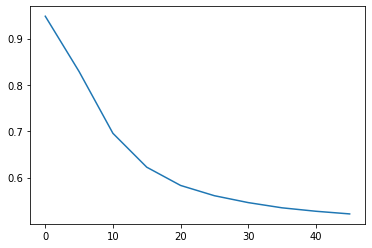

In [111]:
svd_model = SVD(hid_dim=64, lr=1e-2, iterations=50, lam=1e-2, verbose=5)
svd_model.fit(user_item_explicit)

In [112]:
svd_model.get_user_recommendations(1)

Recommendations: 
Cape Fear (1991) [Thriller]
On the Beach (1959) [Drama]
Exorcist, The (1973) [Horror]
Fatal Attraction (1987) [Thriller]
Christmas Vacation (1989) [Comedy]


In [113]:
svd_model.find_similar_items(1)

Similars for 'Toy Story (1995) [Animation|Children's|Comedy]':
Toy Story (1995) [Animation|Children's|Comedy]
Toy Story 2 (1999) [Animation|Children's|Comedy]
Bug's Life, A (1998) [Animation|Children's|Comedy]
Confessional, The (Le Confessionnal) (1995) [Drama|Mystery]
Leather Jacket Love Story (1997) [Drama|Romance]


### Задание 2. Не использую готовые решения, реализовать матричное разложение используя ALS на implicit данных

In [121]:
class ALS:
    def __init__(self, hid_dim: int, lr: float, iterations: int, 
                 lam: float, verbose: int = 1):
        self._hid_dim = hid_dim
        self._lr = lr
        self._lam = lam
        self._iterations = iterations
        self._verbose = verbose
        self.U = None
        self.Y = None
    
    def _init_weihts(self, n_w: int, n_h: int):
        self.U = np.random.uniform(0, np.sqrt(1 / self._hid_dim), size=(n_w, self._hid_dim))
        self.Y = np.random.uniform(0, np.sqrt(1 / self._hid_dim), size=(n_h, self._hid_dim))

    def _step(self, user_item: csr_matrix, A: np.ndarray, B: np.array):
        B_copy = B.copy()
        inv_matrix = np.linalg.inv(A.T @ A + self._lam * np.identity(self._hid_dim))
        grads = csr_matrix(inv_matrix @ A.T)

        for i in range(B_copy.shape[0]):
            R_i = user_item.getrow(i).T
            # print(R_i.shape)
            B_copy[i] = (grads @ R_i).toarray().squeeze()

        return B_copy

    def fit(self, use_item_implicit: csr_matrix):
        self._init_weihts(use_item_implicit.shape[0], use_item_implicit.shape[1])
        losses = []
        iters = []

        for iter in tqdm(range(self._iterations)):
            self.U = self._step(use_item_implicit, self.Y, self.U)
            self.Y = self._step(use_item_implicit.T, self.U, self.Y)
            
            # logging
            if iter % self._verbose == 0:
                y_pred = (self.U @ self.Y.T)[use_item_implicit.nonzero()]
                y_true = use_item_implicit.data
                rmse_error = rmse(y_pred, y_true)
                
                losses.append(rmse_error)
                iters.append(iter)
                
                print(f'{iter}: error: {rmse_error}')
        
        plt.plot(iters, losses)

    def find_similar_items(self, item, number=5) -> np.ndarray:
        best_dist = cosine_similarity(self.Y)[item]
        best_items = np.argsort(-best_dist)[:number]
        best_items = [item_names[x] for x in best_items]
        print(f"Similars for '{item_names[item]}':")
        print('\n'.join(best_items))

    def get_user_recommendations(self, user, number=5) -> np.ndarray:
        best_dist = self.Y @ self.U[user]
        best_items = np.argsort(-best_dist)[:number]
        best_items = [item_names[x] for x in best_items]
        print(f"Recommendations: ")
        print('\n'.join(best_items))

  0%|          | 0/15 [00:00<?, ?it/s]

0: error: 0.7259584536846612
5: error: 0.6395250695129375
10: error: 0.6384952329352368


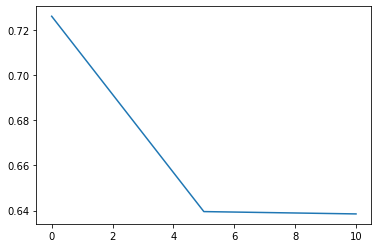

In [125]:
als_model = ALS(hid_dim=64, lr=1e-2, iterations=15, lam=0, verbose=5)
als_model.fit(user_item_csr)

In [126]:
als_model.get_user_recommendations(1)

Recommendations: 
Toy Story 2 (1999) [Animation|Children's|Comedy]
Toy Story (1995) [Animation|Children's|Comedy]
Saving Private Ryan (1998) [Action|Drama|War]
Schindler's List (1993) [Drama|War]
Back to the Future (1985) [Comedy|Sci-Fi]


In [127]:
als_model.find_similar_items(1)

Similars for 'Toy Story (1995) [Animation|Children's|Comedy]':
Toy Story (1995) [Animation|Children's|Comedy]
Toy Story 2 (1999) [Animation|Children's|Comedy]
Bug's Life, A (1998) [Animation|Children's|Comedy]
Aladdin (1992) [Animation|Children's|Comedy|Musical]
League of Their Own, A (1992) [Comedy|Drama]


### Задание 3. Не использую готовые решения, реализовать матричное разложение BPR на implicit данных

### Задание 4. Не использую готовые решения, реализовать матричное разложение WARP на implicit данных